In [57]:
# imports
import json
import matplotlib.pyplot as plt
import numpy as np
import cmdstanpy as cs
import arviz as az
from scipy.stats import truncnorm, norm, halfnorm, invgamma, gamma, beta, halfcauchy
from tabulate import tabulate
from sklearn.neighbors import KernelDensity
from scipy.stats import norm, halfcauchy, gamma
import seaborn as sns
import math

In [10]:
# cs.install_cmdstan()

CmdStan install directory: C:\Users\mes22ss\.cmdstan
Installing CmdStan version: 2.33.1
Download successful, file: C:\Users\mes22ss\AppData\Local\Temp\tmpseqm6vnu
Extracting distribution
Unpacked download as cmdstan-2.33.1
Building version cmdstan-2.33.1, may take several minutes, depending on your system.
Installed cmdstan-2.33.1
Test model compilation


True

### Load surrogate data points / model

In [24]:
# load surrogate/FE generated data points
s_surr = np.genfromtxt(r'C:\Users\mes22ss\Ansys\PythonScripts\foundation_modelling\model_characterisation\x_true_model_characterisation.csv', delimiter=',')
wn_surr = np.genfromtxt(r'C:\Users\mes22ss\Ansys\PythonScripts\foundation_modelling\model_characterisation\y_true_model_characterisation.csv', delimiter=',')

s_surr_mean = np.mean(s_surr)
wn_surr_mean = np.mean(wn_surr)
s_surr_std = np.std(s_surr)
wn_surr_std = np.std(wn_surr)

# Get surrogate model coefficients
coefficients = np.polyfit(s_surr, wn_surr, 5)

def surrogate(x):
    y = np.empty([np.size(x), 1]) # empty array
    y = coefficients[0]*(x ** 5) + coefficients[1]*(x ** 4) + coefficients[2]*(x ** 3) + coefficients[3]*(x ** 2) + coefficients[4]*(x ** 1) + coefficients[5]
    return y

### Generate stiffness / nat freq data

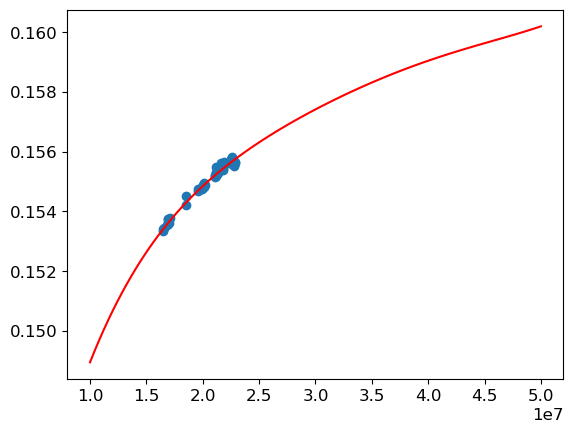

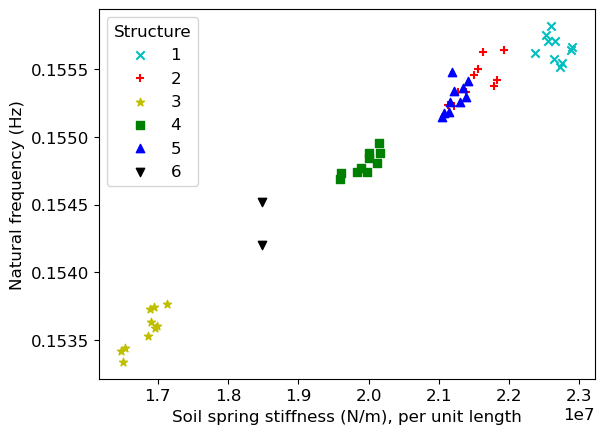

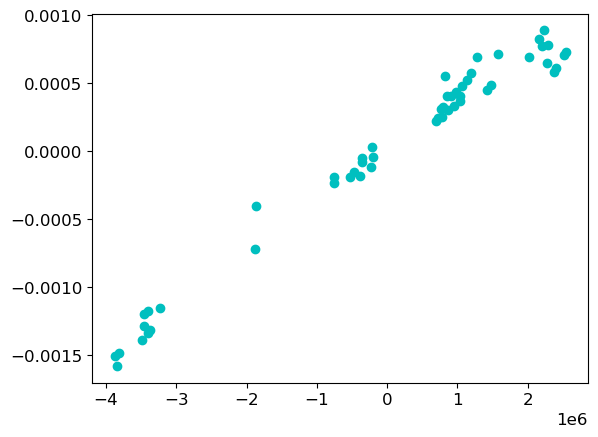

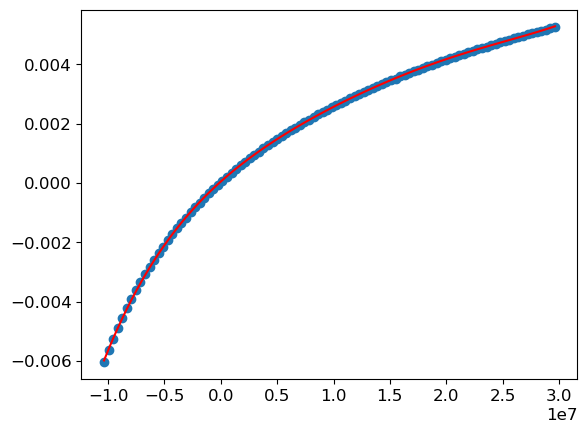

In [53]:
#np.random.seed(100) # for reproducability
np.random.seed(10) # playing around

# Define *True* global parameters
K = 5 # number of balanced class turbines
Nk = 10 # Number of observations per turbine
Eloc = 2e7
Escale = 2e6 # (this is standard deviation not variance)
Vloc = 2e5
Vscale = 2e4 # (this is standard deviation not variance)
gamma_true = 0.0001

# adding imbalanced classes
imb_K = 1 # number of imbalanced class turbines
Nimb = 2 # number of observations per imbalanced turbine

# Draw turbine level expectation and variance parameters
Esk = norm.rvs(loc=Eloc, scale=Escale, size=(K + imb_K,))
Vsk = norm.rvs(loc=Vloc, scale=Vscale, size=(K + imb_K,))

# list of associated turbines for each observation
I = []
for i in range(K):
    I = np.append(I,(i+1)*np.ones(Nk)) 

wn = [] # natural frequency list
s = [] # foundation stiffness list

# wn measurement noise - Is this right? Every measurement should be unique I think
#noise = gamma_true*norm.rvs(loc=0, scale=1, size = Nk) # old
noise = gamma_true*norm.rvs(loc=0, scale=1, size = K*Nk) # new

for k in range(K):
# for k in range(K-2):
    sk = norm.rvs(loc=Esk[k], scale=Vsk[k], size=Nk) # draw stiffness values for each turbine
    wnk = surrogate(sk) # compute natural frequency
    #wn = np.append(wn, wnk + noise) # old - add associated noise to each natural frequency
    wn = np.append(wn, wnk + noise[I==(k+1)]) # new
    s = np.append(s, sk) # store stiffness values

# # imbalanced turbines
if imb_K != 0:
    for k in range(imb_K):
        I = np.append(I,(k+K+1)*np.ones(Nimb)) # update list of turbines
        noise = np.append(noise, gamma_true*norm.rvs(loc=0, scale=1, size=Nimb)) 
        sk = norm.rvs(loc=Esk[K+k], scale=Vsk[K+k], size=Nimb)
        wnk = surrogate(sk)
        wn = np.append(wn, wnk + noise[I==(K+k+1)])
        s = np.append(s, sk)

# # imbalanced turbine 2
# sk = norm.rvs(loc=Esk[K-1], scale=Vsk[K-1], size=5)
# wnk = surrogate(sk)
# wn_calc = np.append(wn_calc, wnk + gamma_true*norm.rvs(loc=0, scale=1, size=5))
# s = np.append(s, sk)

# z_s = (s - np.mean(s))/np.std(s)
# z_wn = (wn - np.mean(wn))/np.std(wn)

# z-transforming or just mean removing
z_s = (s - np.mean(s))
z_wn = (wn - np.mean(wn))
# z_s_surr = (s_surr - np.mean(s))/np.std(s)
# z_wn_surr = (wn_surr - np.mean(wn))/np.std(wn)

z_s_surr = (s_surr - np.mean(s))
z_wn_surr = (wn_surr - np.mean(wn))
z_coefficients = np.polyfit(z_s_surr, z_wn_surr, 5)

plt.figure()
plt.scatter(s,wn)
plt.plot(s_surr, np.poly1d(coefficients)(s_surr), c='r')
#plt.scatter(s_surr,wn_surr, c='c')

plt.figure()
colors = ["c", "r", "y", "g", "b", "k"]*10000
marks = ["x", "+", "*", "s", "^", "v", ".", "o", "<", "<"]*10000
labels = ["1", "2", "3", "4", "5"]*10000
#plt.scatter(s[0:Nk],wn[0:Nk],color=colors[0])

for k in range(K):
    #plt.scatter(s[(k+1)*Nk+k:(k+2)*Nk],wn_calc[(k+1)*Nk+k:(k+2)*Nk],color=colors[k+1])
    plt.scatter(s[k*Nk:(k+1)*Nk],wn[k*Nk:(k+1)*Nk],color=colors[k], marker=marks[k], label=labels[k])
for k in range(imb_K):
    plt.scatter(s[I==K+k+1],wn[I==K+k+1],color=colors[k+K], marker=marks[k+K], label=str(K+k+1))

plt.legend(title="Structure")
plt.xlabel('Soil spring stiffness (N/m), per unit length')
plt.ylabel('Natural frequency (Hz)')

# # imbalanced
# for k in range(K-2):
#     #plt.scatter(s[(k+1)*Nk+k:(k+2)*Nk],wn_calc[(k+1)*Nk+k:(k+2)*Nk],color=colors[k+1])
#     plt.scatter(s[k*Nk:(k+1)*Nk],wn_calc[k*Nk:(k+1)*Nk],color=colors[k])
# plt.scatter(s[500:510],wn_calc[500:510],color="k")
# plt.scatter(s[510:515],wn_calc[510:515], s=200)

# plotting
plt.figure()
plt.scatter(z_s,z_wn, c='c')
plt.figure()
plt.scatter(z_s_surr, z_wn_surr)
plt.plot(z_s_surr, np.poly1d(z_coefficients)(z_s_surr), c='r')



In [58]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [63]:
weights = []
for k in range(K):
    weights = np.append(weights, Nk)
for k in range(imb_K):
    weights = np.append(weights, Nimb)

stds = []
for k in range(K + imb_K):
    stds = np.append(stds, np.std(s[I==k+1]))

In [65]:
gen_Emu = np.mean(s)
gen_Vmu = np.std(s)
# gen_Esig = np.mean(stds)
# gen_Vsig = np.std(stds)
gen_Esig, gen_Vsig = weighted_avg_and_std(stds, weights)
gen_noise = np.std(wn - np.poly1d(coefficients)(s))

print("generated data")
print("Emu: " + str(gen_Emu))
print("Vmu: " + str(gen_Vmu))
print("Esig: " + str(gen_Esig))
print("Vsig: " + str(gen_Vsig))
print("gamma: " + str(gen_noise))


generated data
Emu: 20358058.207008608
Vmu: 2008480.8337815118
Esig: 181891.46664609216
Vsig: 58843.95544726611
gamma: 9.556967801340766e-05


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

<Figure size 640x480 with 0 Axes>

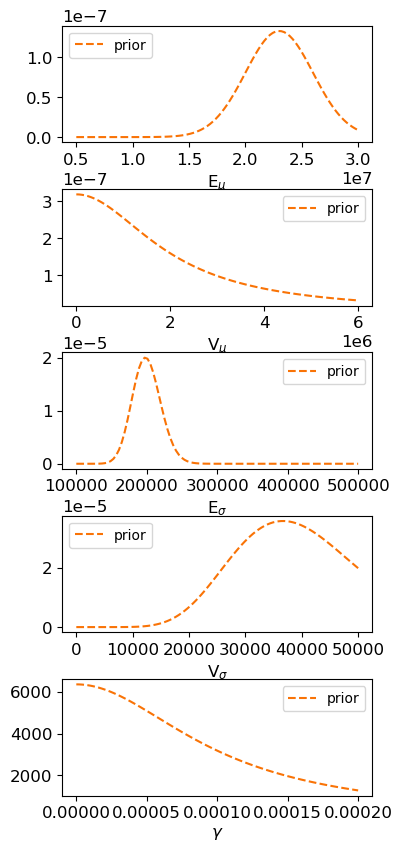

<Figure size 640x480 with 0 Axes>

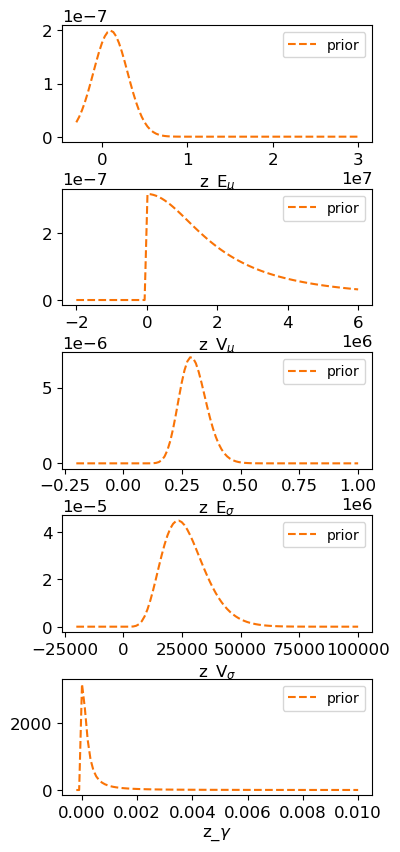

In [66]:
# # true values
# Eloc = 2e7
# Escale = 2e6
# Vloc = 2e5
# Vscale = 2e4
# gamma_true = 0.0001


### define priors

# ----- untransformed priors -----
# Emu0 = [23e6, 3e6] #2e7
# Vmu0 = [15e5, 5e5] #2e6 
# Esig0 = [3e5, 1e5] #2e5 
# Vsig0 = [25e3, 1e4] #2e4 
# sigma0 = [0, 0.1]

Emu0 = [23e6, 3e6] # normal
Vmu0 = [0, 2e6] # halfcauchy
#Vmu0 = [0.5, 25e-8] # gamma
#Esig0 = [3e5, 1e5] # normal
#Esig0 = [27, 9e-5] # gamma
Esig0 = [100, 5e-4] # gamma
#Esig0 = [200, 5e-4] # gamma
#Vsig0 = [0, 3e4] # halfcauchy
Vsig0 = [12, 3e-4] # gamma
#gamma0 = [1, 10000] # gamma
gamma0 = [0, 1e-4] # halfcauchy


# ----- transformed priors -----
# z- transformed versions
# z_Emu0 = [3, 2] # normal
# z_Vmu0 = [0, 0.5] # halfcauchy
# #z_Vmu0 = [1, 1] # gamma
# z_Esig0 = [1, 1] # gamma
# z_Vsig0 = [1, 1] # gamma
# #z_gamma0 = [1, 1] # gamma
# # z_Vmu0 = [0, 0.5] # halfcauchy
# # z_Esig0 = [0, 0.5] # halfcauchy
# # z_Vsig0 = [0, 0.5] # halfcauchy
# z_gamma0 = [0, 0.5] # halfcauchy

# mean removed versions
z_Emu0 = [1e6, 2e6] # normal
z_Vmu0 = [0, 2e6] # halfcauchy
z_Esig0 = [27, 9e-5] # gamma
z_Vsig0 = [8, 3e-4] # gamma
z_gamma0 = [0, 2e-4] # halfcauchy


#priors for plotting
plt.figure()
Emu_x = np.linspace(5e6, 30e6, 100)
Emu_y = norm.pdf(Emu_x, Emu0[0], Emu0[1])
Vmu_x = np.linspace(0, 6e6, 100)
#Vmu_y = gamma.pdf(Vmu_x, a=Vmu0[0], scale=1/Vmu0[1])
Vmu_y = halfcauchy.pdf(Vmu_x, Vmu0[0], Vmu0[1])

Esig_x = np.linspace(1e5, 5e5, 100)
#Esig_y = norm.pdf(Esig_x, Esig0[0], Esig0[1])
Esig_y = gamma.pdf(Esig_x, a=Esig0[0], scale=1/Esig0[1])
Vsig_x = np.linspace(0, 5e4, 100)
#Vsig_y = halfcauchy.pdf(Vsig_x, Vsig0[0], Vsig0[1])
Vsig_y = gamma.pdf(Vsig_x, a=Vsig0[0], scale=1/Vsig0[1])

gamma_x = np.linspace(0, 0.0002, 100)
#gamma_y = gamma.pdf(gamma_x, a=gamma0[0], scale=1/gamma0[1])
gamma_y = halfcauchy.pdf(gamma_x, gamma0[0], gamma0[1])

plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(5,1,figsize=(4,10))
fig.subplots_adjust(hspace=0.4) # adjust subplot spacing

plt.subplot(5,1,1)
plt.plot(Emu_x, Emu_y, color="#F97306", linestyle="--", label="prior")
plt.xlabel('E$_\mu$')
plt.legend(fontsize=10)

plt.subplot(5,1,2)
plt.plot(Vmu_x, Vmu_y, color="#F97306", linestyle="--", label="prior")
plt.xlabel('V$_\mu$')
plt.legend(fontsize=10)

plt.subplot(5,1,3)
plt.plot(Esig_x, Esig_y, color="#F97306", linestyle="--", label="prior")
plt.xlabel('E$_\sigma$')
plt.legend(fontsize=10)


plt.subplot(5,1,4)
plt.plot(Vsig_x, Vsig_y, color="#F97306", linestyle="--", label="prior")
plt.xlabel('V$_\sigma$')
plt.legend(fontsize=10)

plt.subplot(5,1,5)
plt.plot(gamma_x, gamma_y, color="#F97306", linestyle="--", label="prior")
plt.xlabel('$\gamma$')
plt.legend(fontsize=10)

plt.tight_layout

# z-transformed
plt.figure()
# z_Emu_x = np.linspace(-8, 8, 100)
# z_Emu_y = norm.pdf(z_Emu_x, z_Emu0[0], z_Emu0[1])
# z_Vmu_x = np.linspace(-8, 8, 100)
# z_Vmu_y = halfcauchy.pdf(z_Vmu_x, z_Vmu0[0], z_Vmu0[1])
# #z_Vmu_y = gamma.pdf(z_Vmu_x, a=z_Vmu0[0], scale=1/z_Vmu0[1])

# z_Esig_x = np.linspace(-8, 8, 100)
# z_Esig_y = gamma.pdf(z_Esig_x, a=z_Esig0[0], scale=1/z_Esig0[1])
# #z_Esig_y = halfcauchy.pdf(z_Esig_x, z_Esig0[0], z_Esig0[1])
# z_Vsig_x = np.linspace(-8, 8, 100)
# z_Vsig_y = gamma.pdf(z_Vsig_x, a=z_Vsig0[0], scale=1/z_Vsig0[1])
# #z_Vsig_y = halfcauchy.pdf(z_Vsig_x, z_Vsig0[0], z_Vsig0[1])

# z_gamma_x = np.linspace(-0.0002, 1, 100)
# #z_gamma_y = gamma.pdf(z_gamma_x, a=z_gamma0[0], scale=1/z_gamma0[1])
# z_gamma_y = halfcauchy.pdf(z_gamma_x, z_gamma0[0], z_gamma0[1])

# mean removed only
z_Emu_x = np.linspace(-3e6, 3e7, 100)
z_Emu_y = norm.pdf(z_Emu_x, z_Emu0[0], z_Emu0[1])
z_Vmu_x = np.linspace(-2e6, 6e6, 100)
z_Vmu_y = halfcauchy.pdf(z_Vmu_x, z_Vmu0[0], z_Vmu0[1])
#z_Vmu_y = gamma.pdf(z_Vmu_x, a=z_Vmu0[0], scale=1/z_Vmu0[1])

z_Esig_x = np.linspace(-2e5, 1e6, 100)
z_Esig_y = gamma.pdf(z_Esig_x, a=z_Esig0[0], scale=1/z_Esig0[1])
#z_Esig_y = halfcauchy.pdf(z_Esig_x, z_Esig0[0], z_Esig0[1])
z_Vsig_x = np.linspace(-2e4, 1e5, 100)
z_Vsig_y = gamma.pdf(z_Vsig_x, a=z_Vsig0[0], scale=1/z_Vsig0[1])
#z_Vsig_y = halfcauchy.pdf(z_Vsig_x, z_Vsig0[0], z_Vsig0[1])

z_gamma_x = np.linspace(-0.0002, 0.01, 100)
#z_gamma_y = gamma.pdf(z_gamma_x, a=z_gamma0[0], scale=1/z_gamma0[1])
z_gamma_y = halfcauchy.pdf(z_gamma_x, z_gamma0[0], z_gamma0[1])

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(5,1,figsize=(4,10))
fig.subplots_adjust(hspace=0.4) # adjust subplot spacing

plt.subplot(5,1,1)
plt.plot(z_Emu_x, z_Emu_y, color="#F97306", linestyle="--", label="prior")
plt.xlabel('z_E$_\mu$')
plt.legend(fontsize=10)

plt.subplot(5,1,2)
plt.plot(z_Vmu_x, z_Vmu_y, color="#F97306", linestyle="--", label="prior")
plt.xlabel('z_V$_\mu$')
plt.legend(fontsize=10)

plt.subplot(5,1,3)
plt.plot(z_Esig_x, z_Esig_y, color="#F97306", linestyle="--", label="prior")
plt.xlabel('z_E$_\sigma$')
plt.legend(fontsize=10)

plt.subplot(5,1,4)
plt.plot(z_Vsig_x, z_Vsig_y, color="#F97306", linestyle="--", label="prior")
plt.xlabel('z_V$_\sigma$')
plt.legend(fontsize=10)

plt.subplot(5,1,5)
plt.plot(z_gamma_x, z_gamma_y, color="#F97306", linestyle="--", label="prior")
plt.xlabel('z_$\gamma$')
plt.legend(fontsize=10)
plt.tight_layout

### Partial pooling model

In [67]:
### partial-pooling model

# # imbalanced bit
# I = np.append(I,5*np.ones(10))
# I = np.append(I,6*np.ones(5))

# print(I)

data = {
    "N": len(I),
    "K": K + imb_K,
    "c": coefficients,
    "I": I.astype(int),
    "wn": wn,
    "Emu0": Emu0,
    "Esig0": Esig0,
    "Vmu0": Vmu0,
    "Vsig0": Vsig0,
    "gamma0": gamma0,
}

#PP = cs.CmdStanModel(stan_file='hierarchical_model.stan')
PP = cs.CmdStanModel(stan_file='hierarchical_model_v2.stan')

ssPP = PP.sample(data, iter_warmup=3000, iter_sampling=2000, adapt_delta=.98,
                    max_treedepth=20, )
# #ssPP = PP.sample(data, iter_warmup=500, iter_sampling=1000, adapt_delta=.98,
#                    max_treedepth=20, )

azPP = az.InferenceData(posterior=ssPP.draws_xr())

14:33:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:34:43 - cmdstanpy - INFO - CmdStan done processing.
14:34:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/mes22ss/AppData/Local/Temp/tmpf7ysh3ny/tmp8kxq4kai.stan', line 37, column 4 to column 36)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'C:/Users/mes22ss/AppData/Local/Temp/tmpf7ysh3ny/tmp8kxq4kai.stan', line 37, column 4 to column 36)
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'C:/Users/mes22ss/AppData/Local/Temp/tmpf7ysh3ny/tmp8kxq4kai.stan', line 37, column 4 to column 36)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'C:/Users/mes22ss/AppData/Local/Temp/tmpf7ysh3ny/tmp8kxq4kai.stan', line 37, column 4 to column 36)
Consider re-running with show_console=True if the above output is unclear!


In [68]:
print(ssPP.diagnose())


Processing csv files: C:\Users\mes22ss\AppData\Local\Temp\tmp0kalcd_i\hierarchical_model_v2gtbihljb\hierarchical_model_v2-20240205143344_1.csv, C:\Users\mes22ss\AppData\Local\Temp\tmp0kalcd_i\hierarchical_model_v2gtbihljb\hierarchical_model_v2-20240205143344_2.csv, C:\Users\mes22ss\AppData\Local\Temp\tmp0kalcd_i\hierarchical_model_v2gtbihljb\hierarchical_model_v2-20240205143344_3.csv, C:\Users\mes22ss\AppData\Local\Temp\tmp0kalcd_i\hierarchical_model_v2gtbihljb\hierarchical_model_v2-20240205143344_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [166]:
print(ssPP.summary())

                Mean         MCSE         StdDev            5%           50%  \
lp__    7.441100e+02     2.314340      23.426200  7.177820e+02  7.387060e+02   
gamma   7.583180e-05     0.000002       0.000026  2.860120e-05  7.832460e-05   
dsk[1]  5.195600e-02     0.007381       0.728872 -1.168860e+00  6.042330e-02   
dsk[2]  6.533140e-01     0.013637       0.765701 -6.563820e-01  6.919640e-01   
dsk[3]  3.618900e-01     0.008379       0.734748 -8.735780e-01  3.769920e-01   
...              ...          ...            ...           ...           ...   
s[48]   2.113212e+07  5750.800000  194005.000000  2.083580e+07  2.112150e+07   
s[49]   2.127790e+07  1593.070000  173435.000000  2.099910e+07  2.126870e+07   
s[50]   2.114598e+07  5496.160000  188221.000000  2.085560e+07  2.113100e+07   
s[51]   1.896651e+07  5018.560000  192975.000000  1.862790e+07  1.898460e+07   
s[52]   1.844850e+07  5400.940000  196387.000000  1.816460e+07  1.842530e+07   

                 95%      N_Eff    N_Ef

C:\Users\mes22ss\AppData\Local\Temp\ipykernel_116820\665030030.py:50: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(posterior_Es[j,:,k], ax=ax[4], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75})
c:\Users\mes22ss\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mes22ss\AppData\Local\Temp\ipykernel_116820\665030030.py:52: UserWarning: 

`distplot` is a deprecated function and w

21071.61868978275


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

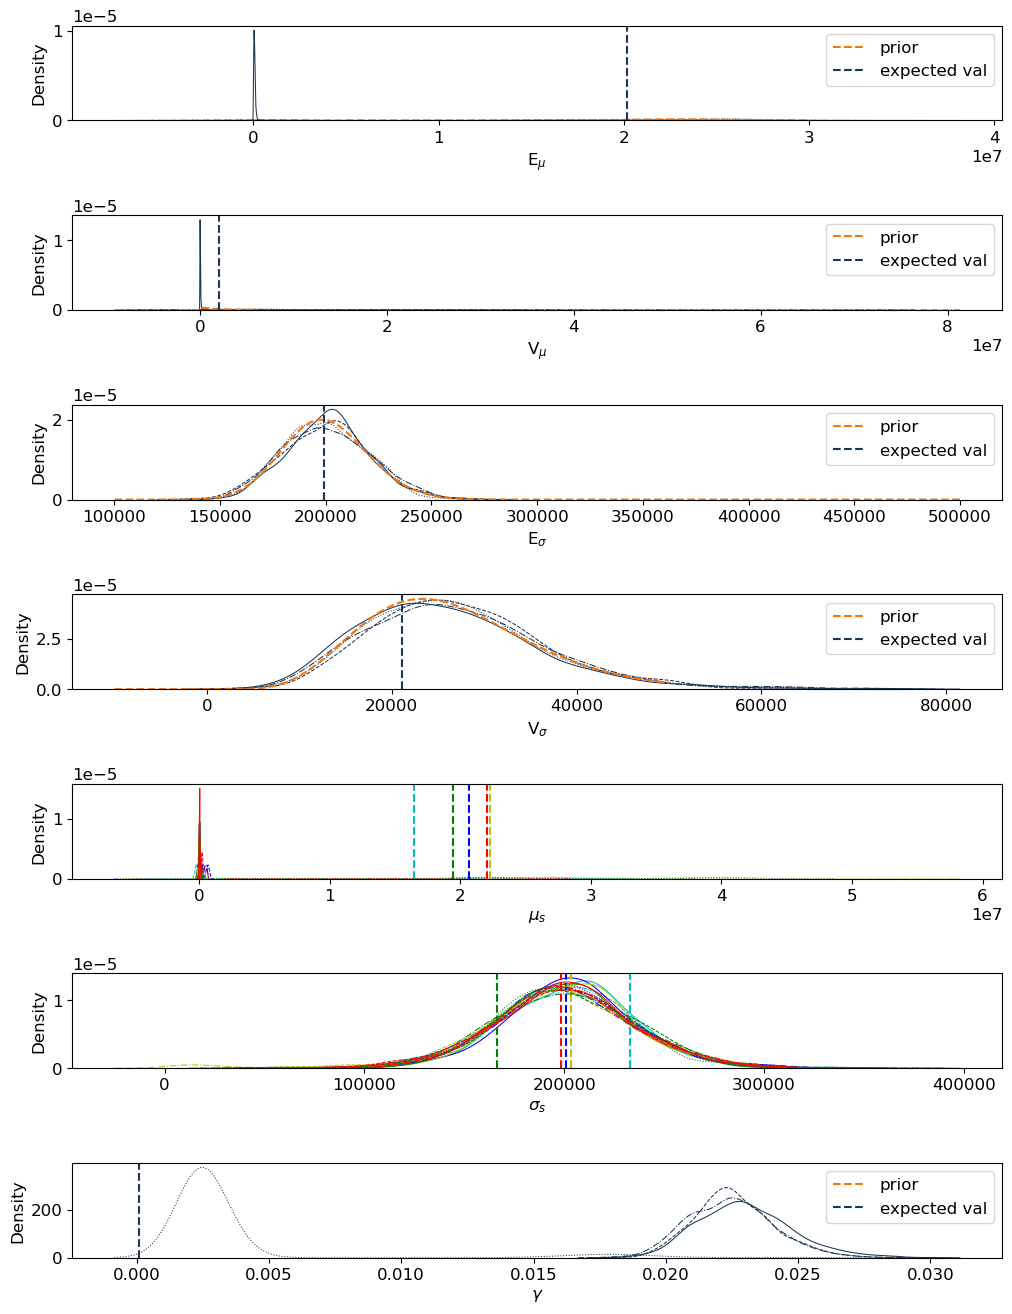

In [25]:
# from scipy.stats import norm, halfcauchy, gamma
# import seaborn as sns

# #priors for plotting
# Emu_x = np.linspace(5e6, 30e6, 100)
# Emu_y = norm.pdf(Emu_x, Emu0[0], Emu0[1])
# Vmu_x = np.linspace(-2e6, 6e6, 100)
# Vmu_y = halfcauchy.pdf(Vmu_x, Vmu0[0], Vmu0[1])
# #Vmu_y = norm.pdf(Vmu_x, Vmu0[0], Vmu0[1])

# Esig_x = np.linspace(1e5, 5e5, 100)
# #Esig_y = norm.pdf(Esig_x, Esig0[0], Esig0[1])
# Esig_y = gamma.pdf(Esig_x, a=Esig0[0], scale=1/Esig0[1])
# Vsig_x = np.linspace(-1e4, 5e4, 100)
# #Vsig_y = halfcauchy.pdf(Vsig_x, Vsig0[0], Vsig0[1])
# Vsig_y = gamma.pdf(Vsig_x, a=Vsig0[0], scale=1/Vsig0[1])
# #Vsig_y = norm.pdf(Vsig_x, Vsig0[0], Vsig0[1])

# gamma_x = np.linspace(0, 0.0003, 100)
# gamma_y = gamma.pdf(gamma_x, a=gamma0[0], scale=1/gamma0[1])
# #gamma_y = norm.pdf(gamma_x, gamma0[0], gamma0[1])


# # posteriors
# posterior_Emu = azPP.posterior.Emu

# posterior_Vmu = azPP.posterior.Vmu

# posterior_Esig = azPP.posterior.Esig

# posterior_Vsig = azPP.posterior.Vsig

# posterior_Es = azPP.posterior.Es
# posterior_Vs = azPP.posterior.Vs
# posterior_gamma = azPP.posterior.gamma


# plt.rcParams.update({'font.size': 12})

# fig, ax = plt.subplots(7,1,figsize=(12,16))
# fig.subplots_adjust(hspace=1) # adjust subplot spacing

# linestyles = ['-', '--', '-.', ':']*4
# colors = ["c", "b", "y", "g", "r"]*16
# labels = ["1", "2", "3", "4", "5"]*4

# for k in range(K):
#     for j in range(4):
#         if j == 0:
#             sns.distplot(posterior_Es[j,:,k], ax=ax[4], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75})
#         else:
#             sns.distplot(posterior_Es[j,:,k], ax=ax[4], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75})
#         plt.subplot(7,1,4)
    
# plt.subplot(7,1,4)
# plt.legend()

# for k in range(K):
#     for j in range(4):
#         if j == 0:
#             sns.distplot(posterior_Vs[j,:,k], ax=ax[5], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75})
#         else:
#             sns.distplot(posterior_Vs[j,:,k], ax=ax[5], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75})
#     plt.subplot(7,1,5)
#     plt.axvline(np.mean(s[k*Nk:(k+1)*Nk]), 0,1, color=colors[k], linestyle="--", label="expected val")
#     plt.subplot(7,1,6)
#     plt.axvline(np.std(s[k*Nk:(k+1)*Nk]), 0,1, color=colors[k], linestyle="--", label="expected val")

# for i in range(4):
#     sns.distplot(posterior_Emu[i,:], ax=ax[0], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[i], 'linewidth':0.75})
#     sns.distplot(posterior_Vmu[i,:], ax=ax[1], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[i], 'linewidth':0.75})
#     sns.distplot(posterior_Esig[i,:], ax=ax[2], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[i], 'linewidth':0.75})
#     sns.distplot(posterior_Vsig[i,:], ax=ax[3], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[i], 'linewidth':0.75})
#     sns.distplot(posterior_gamma[i,:], ax=ax[6], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[i], 'linewidth':0.75})
   

# plt.subplot(7,1,1)
# plt.plot(Emu_x, Emu_y, color="#F97306", linestyle="--", label="prior")
# plt.axvline(np.mean(Esk), 0,1, color='#1D3557', linestyle="--", label="expected val")
# plt.xlabel('E$_\mu$')
# plt.legend()

# plt.subplot(7,1,2)
# plt.plot(Vmu_x, Vmu_y, color="#F97306", linestyle="--", label="prior")
# plt.axvline(np.std(Esk), 0,1, color='#1D3557', linestyle="--", label="expected val")
# plt.xlabel('V$_\mu$')
# plt.legend()

# plt.subplot(7,1,3)
# plt.plot(Esig_x, Esig_y, color="#F97306", linestyle="--", label="prior")
# plt.axvline(np.mean(Vsk), 0,1, color='#1D3557', linestyle="--", label="expected val")
# plt.xlabel('E$_\sigma$')
# plt.legend()

# stds = []
# for k in range(K):
#     stds.append(np.std(s[Nk*k:Nk*(k+1)]))
# stds = np.std(stds)
# print(stds)


# plt.subplot(7,1,4)
# plt.plot(Vsig_x, Vsig_y, color="#F97306", linestyle="--", label="prior")
# plt.axvline(stds, 0,1, color='#1D3557', linestyle="--", label="expected val")
# plt.xlabel('V$_\sigma$')
# plt.legend()


# plt.subplot(7,1,5)
# plt.xlabel('${\mu}_s$')

# plt.subplot(7,1,6)
# plt.xlabel('${\sigma}_s$')

# plt.subplot(7,1,7)
# plt.plot(gamma_x, gamma_y, color="#F97306", linestyle="--", label="prior")
# plt.axvline(gamma_true, 0,1, color='#1D3557', linestyle="--", label="expected val")
# plt.xlabel('$\gamma$')
# plt.legend()

# plt.tight_layout



### Untransformed model

C:\Users\mes22ss\AppData\Local\Temp\ipykernel_77476\3900157310.py:51: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(posterior_Es[j,:,k], ax=ax[2,0], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75}, label=str(k+1))
c:\Users\mes22ss\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mes22ss\AppData\Local\Temp\ipykernel_77476\3900157310.py:53: UserWarning: 

`distplot` is a depreca

47804.24528475287


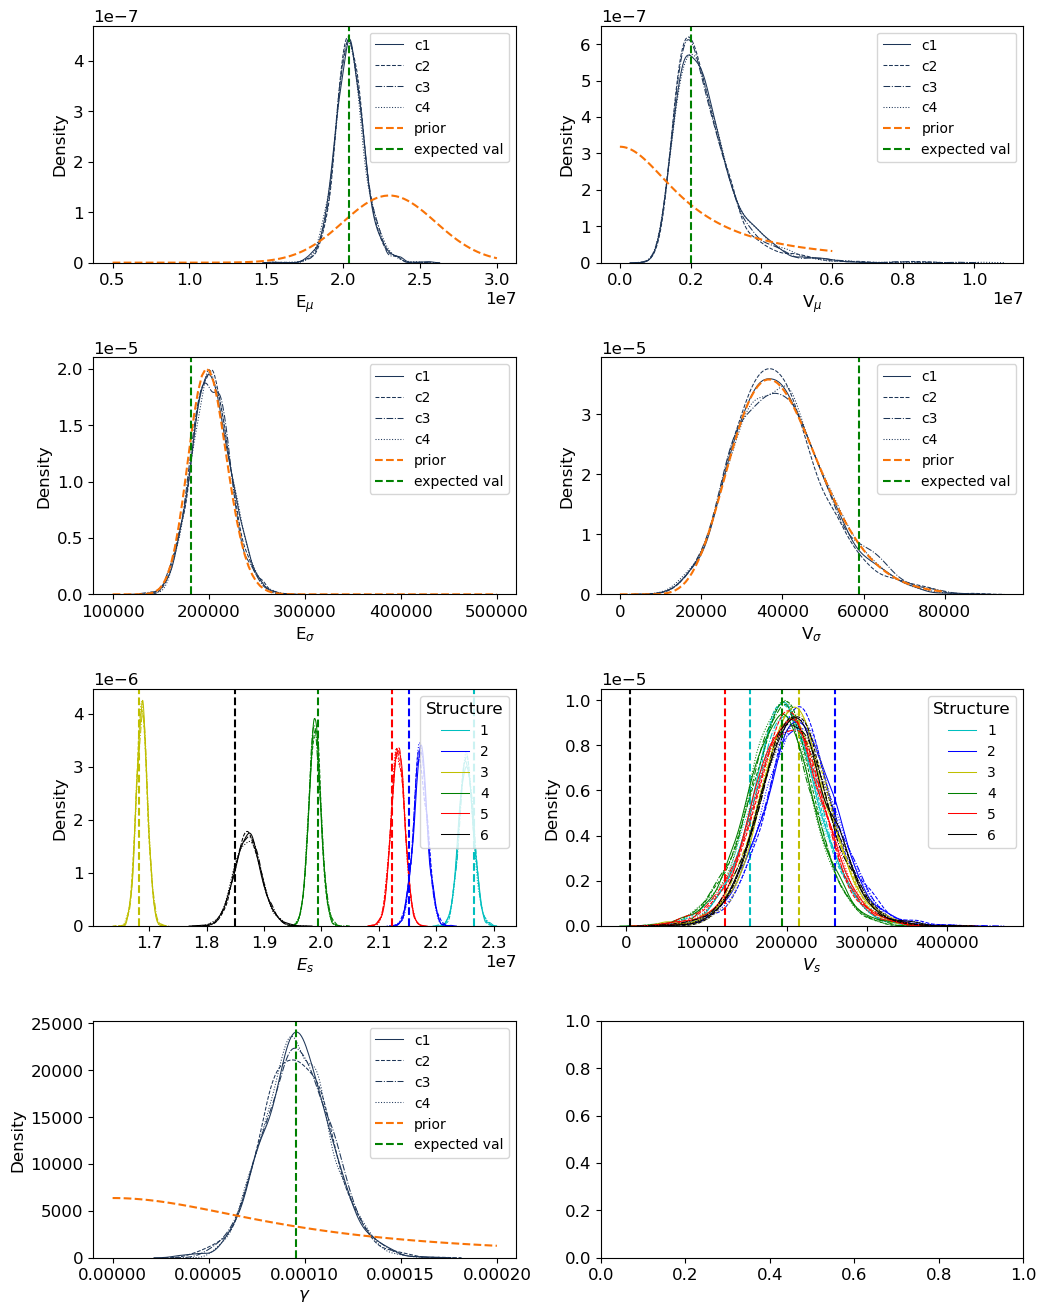

In [70]:
from scipy.stats import norm, halfcauchy
import seaborn as sns

#priors for plotting
Emu_x = np.linspace(5e6, 30e6, 100)
Emu_y = norm.pdf(Emu_x, Emu0[0], Emu0[1])
Vmu_x = np.linspace(0, 6e6, 100)
#Vmu_y = norm.pdf(Vmu_x, Vmu0[0], Vmu0[1])

Esig_x = np.linspace(1e5, 5e5, 100)
#Esig_y = norm.pdf(Esig_x, Esig0[0], Esig0[1])
Vsig_x = np.linspace(0, 8e4, 100)
#Vsig_y = norm.pdf(Vsig_x, Vsig0[0], Vsig0[1])

gamma_x = np.linspace(0, 0.0002, 100)
#gamma_y = norm.pdf(gamma_x, gamma0[0], gamma0[1])


#Vmu_y = gamma.pdf(Vmu_x, a=Vmu0[0], scale=1/Vmu0[1])
Vmu_y = halfcauchy.pdf(Vmu_x, Vmu0[0], Vmu0[1])
Esig_y = gamma.pdf(Esig_x, a=Esig0[0], scale=1/Esig0[1])
Vsig_y = gamma.pdf(Vsig_x, a=Vsig0[0], scale=1/Vsig0[1])
#gamma_y = gamma.pdf(gamma_x, a=gamma0[0], scale=1/gamma0[1])
gamma_y = halfcauchy.pdf(gamma_x, gamma0[0], gamma0[1])

# posteriors
posterior_Emu = azPP.posterior.Emu
posterior_Vmu = azPP.posterior.Vmu

posterior_Esig = azPP.posterior.Esig
posterior_Vsig = azPP.posterior.Vsig

posterior_Es = azPP.posterior.Es
posterior_Vs = azPP.posterior.Vs
posterior_gamma = azPP.posterior.gamma

posterior_s = azPP.posterior.s

plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(4,2,figsize=(12,16))
fig.subplots_adjust(hspace=0.4) # adjust subplot spacing

linestyles = ['-', '--', '-.', ':']*4
colors = ["c", "b", "y", "g", "r", "k"]*16
labels = ["1", "2", "3", "4", "5"]*4

for k in range(K + imb_K):
    for j in range(4):
        if j == 0:
            sns.distplot(posterior_Es[j,:,k], ax=ax[2,0], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75}, label=str(k+1))
        else:
            sns.distplot(posterior_Es[j,:,k], ax=ax[2,0], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75})
        plt.subplot(4,2,4)

plt.subplot(4,2,4)

for k in range(K + imb_K):
    for j in range(4):
        if j == 0:
            sns.distplot(posterior_Vs[j,:,k], ax=ax[2,1], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75, 'label':str(k+1)})
        else:
            sns.distplot(posterior_Vs[j,:,k], ax=ax[2,1], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75})
    plt.subplot(4,2,5)
    plt.axvline(np.mean(s[I==k+1]), 0,1, color=colors[k], linestyle="--")
    plt.legend(title="Structure", loc=1, fontsize=10)
    plt.subplot(4,2,6)
    plt.axvline(np.std(s[I==k+1]), 0,1, color=colors[k], linestyle="--")
    plt.legend(title="Structure", loc=1, fontsize=10)

for i in range(4):
    sns.distplot(posterior_Emu[i,:], ax=ax[0,0], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
    sns.distplot(posterior_Vmu[i,:], ax=ax[0,1], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
    sns.distplot(posterior_Esig[i,:], ax=ax[1,0], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
    sns.distplot(posterior_Vsig[i,:], ax=ax[1,1], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
    sns.distplot(posterior_gamma[i,:], ax=ax[3,0], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
   

plt.subplot(4,2,1)
plt.plot(Emu_x, Emu_y, color="#F97306", linestyle="--", label="prior")
plt.axvline(gen_Emu, 0,1, color='g', linestyle="--", label="expected val")
plt.xlabel('E$_\mu$')
plt.legend(fontsize=10)

plt.subplot(4,2,2)
plt.plot(Vmu_x, Vmu_y, color="#F97306", linestyle="--", label="prior")
plt.axvline(gen_Vmu, 0,1, color='g', linestyle="--", label="expected val")
plt.xlabel('V$_\mu$')
plt.legend(fontsize=10)

plt.subplot(4,2,3)
plt.plot(Esig_x, Esig_y, color="#F97306", linestyle="--", label="prior")
plt.axvline(gen_Esig, 0,1, color='g', linestyle="--", label="expected val")
plt.xlabel('E$_\sigma$')
plt.legend(fontsize=10)

stds = []
for k in range(K):
    stds.append(np.std(s[I==k+1]))
stds = np.std(stds)
print(stds)


plt.subplot(4,2,4)
plt.plot(Vsig_x, Vsig_y, color="#F97306", linestyle="--", label="prior")
plt.axvline(gen_Vsig, 0,1, color='g', linestyle="--", label="expected val")
plt.xlabel('V$_\sigma$')
plt.legend(fontsize=10)


plt.subplot(4,2,5)
plt.xlabel('$E_s$')

plt.subplot(4,2,6)
plt.xlabel('$V_s$')

plt.subplot(4,2,7)
plt.plot(gamma_x, gamma_y, color="#F97306", linestyle="--", label="prior")
plt.axvline(gen_noise, 0,1, color='g', linestyle="--", label="expected val")
plt.xlabel('$\gamma$')
plt.legend(fontsize=10)

plt.tight_layout;



### Z-transformed model

C:\Users\mes22ss\AppData\Local\Temp\ipykernel_116820\3252463979.py:59: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(posterior_Es[j,:,k], ax=ax[2,0], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75}, label=str(k+1))
c:\Users\mes22ss\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mes22ss\AppData\Local\Temp\ipykernel_116820\3252463979.py:61: UserWarning: 

`distplot` is a depre

81692.70038637261


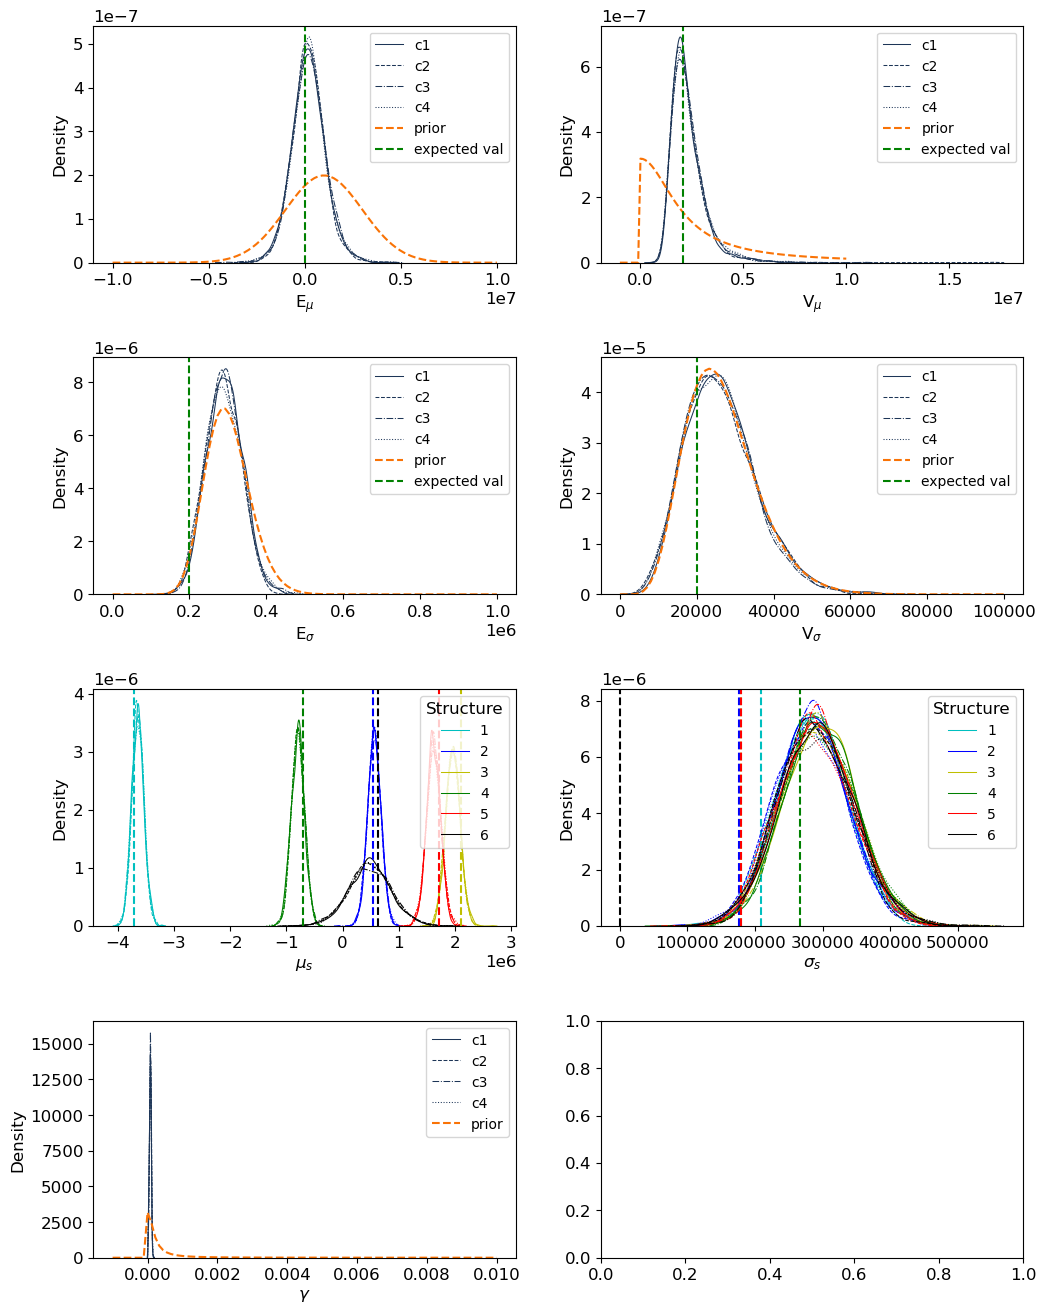

In [124]:
from scipy.stats import norm, halfcauchy
import seaborn as sns

#priors for plotting
z_Emu_x = np.linspace(-1e7, 1e7, 100)
z_Emu_y = norm.pdf(z_Emu_x, z_Emu0[0], z_Emu0[1])
z_Vmu_x = np.linspace(-1e6, 1e7, 100)
z_Vmu_y = halfcauchy.pdf(z_Vmu_x, z_Vmu0[0], z_Vmu0[1])
#z_Vmu_y = gamma.pdf(z_Vmu_x, a=z_Vmu0[0], scale=1/z_Vmu0[1])

z_Esig_x = np.linspace(0, 1e6, 100)
z_Esig_y = gamma.pdf(z_Esig_x, a=z_Esig0[0], scale=1/z_Esig0[1])
#z_Esig_y = halfcauchy.pdf(z_Esig_x, z_Esig0[0], z_Esig0[1])
z_Vsig_x = np.linspace(0, 1e5, 100)
z_Vsig_y = gamma.pdf(z_Vsig_x, a=z_Vsig0[0], scale=1/z_Vsig0[1])
#z_Vsig_y = halfcauchy.pdf(z_Vsig_x, z_Vsig0[0], z_Vsig0[1])

z_gamma_x = np.linspace(-1e-3, 1e-2, 100)
#z_gamma_y = gamma.pdf(z_gamma_x, a=z_gamma0[0], scale=1/z_gamma0[1])
z_gamma_y = halfcauchy.pdf(z_gamma_x, z_gamma0[0], z_gamma0[1])


# posteriors
posterior_Emu = azPP.posterior.Emu
posterior_Vmu = azPP.posterior.Vmu

posterior_Esig = azPP.posterior.Esig
posterior_Vsig = azPP.posterior.Vsig

posterior_Es = azPP.posterior.Es
posterior_Vs = azPP.posterior.Vs
posterior_gamma = azPP.posterior.gamma

posterior_s = azPP.posterior.s

plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(4,2,figsize=(12,16))
fig.subplots_adjust(hspace=0.4) # adjust subplot spacing

linestyles = ['-', '--', '-.', ':']*4
colors = ["c", "b", "y", "g", "r", "k"]*16
labels = ["1", "2", "3", "4", "5"]*4

# for k in range(K):
#     for j in range(4):
#         if j == 0:
#             sns.distplot(posterior_Es[j,:,k], ax=ax[2,0], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75}, label=str(k+1))
#         else:
#             sns.distplot(posterior_Es[j,:,k], ax=ax[2,0], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75})
#         plt.subplot(4,2,4)

# plt.subplot(4,2,4)

for k in range(K + imb_K):
    for j in range(4):
        if j == 0:
            sns.distplot(posterior_Es[j,:,k], ax=ax[2,0], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75}, label=str(k+1))
        else:
            sns.distplot(posterior_Es[j,:,k], ax=ax[2,0], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75})
        plt.subplot(4,2,4)

plt.subplot(4,2,4)


for k in range(K + imb_K):
    for j in range(4):
        if j == 0:
            sns.distplot(posterior_Vs[j,:,k], ax=ax[2,1], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75, 'label':str(k+1)})
        else:
            sns.distplot(posterior_Vs[j,:,k], ax=ax[2,1], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75})
    plt.subplot(4,2,5)
    plt.axvline(np.mean(z_s[I==k+1]), 0,1, color=colors[k], linestyle="--")
    plt.legend(title="Structure", loc=1, fontsize=10)
    plt.subplot(4,2,6)
    plt.axvline(np.std(z_s[I==k+1]), 0,1, color=colors[k], linestyle="--")
    plt.legend(title="Structure", loc=1, fontsize=10)



for i in range(4):
    sns.distplot(posterior_Emu[i,:], ax=ax[0,0], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
    sns.distplot(posterior_Vmu[i,:], ax=ax[0,1], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
    sns.distplot(posterior_Esig[i,:], ax=ax[1,0], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
    sns.distplot(posterior_Vsig[i,:], ax=ax[1,1], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
    sns.distplot(posterior_gamma[i,:], ax=ax[3,0], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
   


#z_Esk = (Esk - np.mean(s))/np.std(s)

plt.subplot(4,2,1)
plt.plot(z_Emu_x, z_Emu_y, color="#F97306", linestyle="--", label="prior")
plt.axvline(np.mean(z_s), 0,1, color='g', linestyle="--", label="expected val")
plt.xlabel('E$_\mu$')
plt.legend(fontsize=10)

plt.subplot(4,2,2)
plt.plot(z_Vmu_x, z_Vmu_y, color="#F97306", linestyle="--", label="prior")
plt.axvline(np.std(z_s), 0,1, color='g', linestyle="--", label="expected val")
plt.xlabel('V$_\mu$')
plt.legend(fontsize=10)

plt.subplot(4,2,3)
plt.plot(z_Esig_x, z_Esig_y, color="#F97306", linestyle="--", label="prior")
plt.axvline(2e5, 0,1, color='g', linestyle="--", label="expected val")
plt.xlabel('E$_\sigma$')
plt.legend(fontsize=10)


stds = []
for k in range(K + imb_K):
    stds.append(np.std(z_s[I==k+1]))
stds = np.std(stds)
print(stds)


plt.subplot(4,2,4)
plt.plot(z_Vsig_x, z_Vsig_y, color="#F97306", linestyle="--", label="prior")
plt.axvline(2e4, 0,1, color='g', linestyle="--", label="expected val")
plt.xlabel('V$_\sigma$')
plt.legend(fontsize=10)


plt.subplot(4,2,5)
plt.xlabel('${\mu}_s$')

plt.subplot(4,2,6)
plt.xlabel('${\sigma}_s$')

plt.subplot(4,2,7)
plt.plot(z_gamma_x, z_gamma_y, color="#F97306", linestyle="--", label="prior")
#plt.axvline(gamma_true/np.std(wn), 0,1, color='g', linestyle="--", label="expected val")
plt.xlabel('$\gamma$')
plt.legend(fontsize=10)

plt.tight_layout;


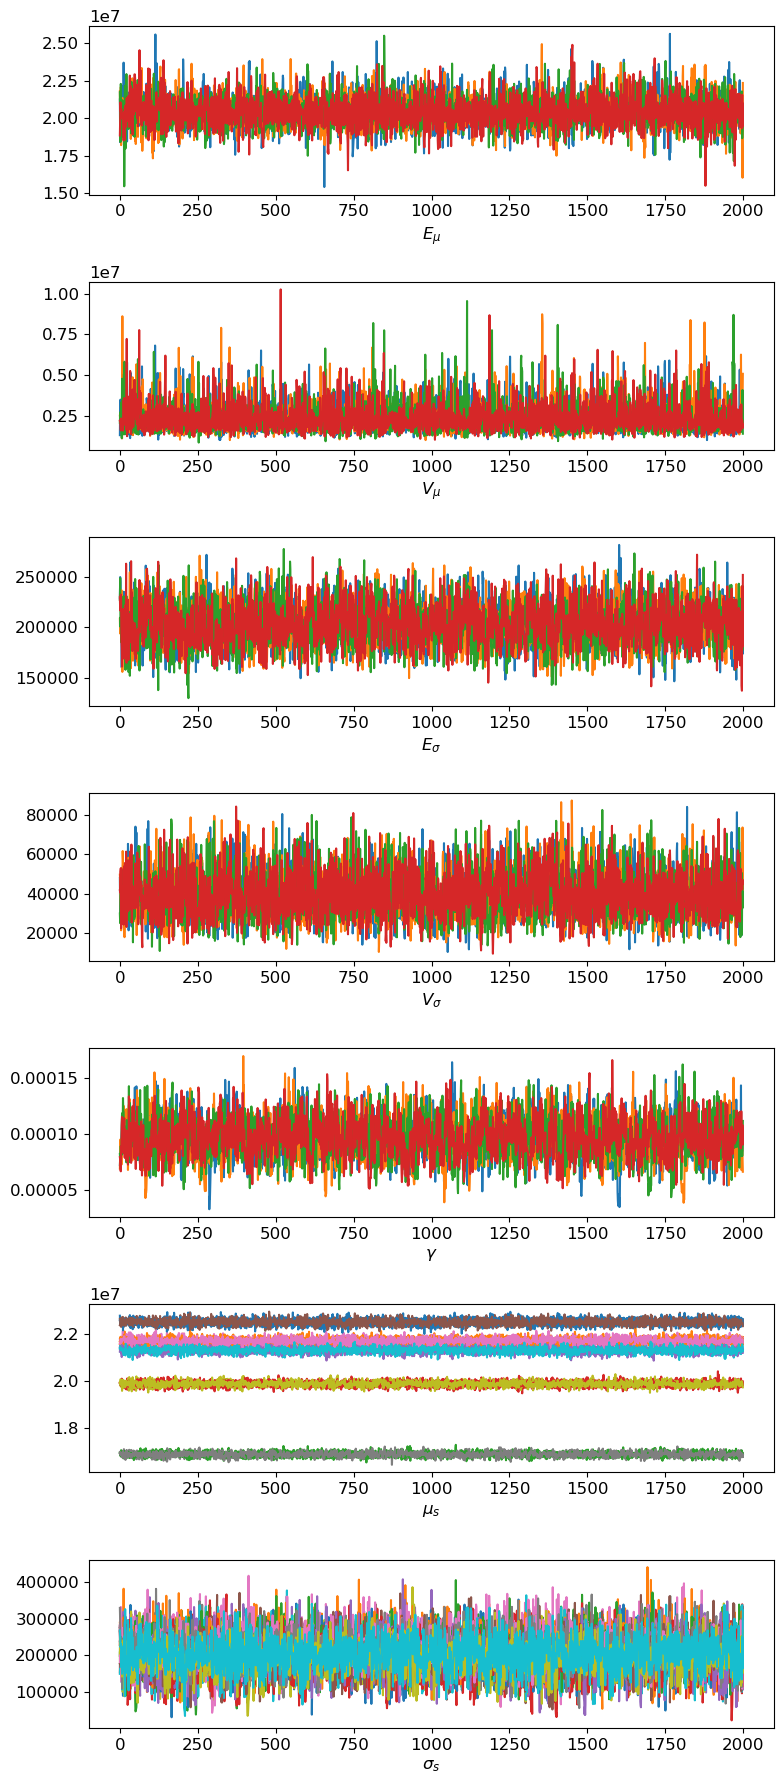

In [71]:

fig, ax = plt.subplots(7,1,figsize=(8,18))

for i in range(4):
    plt.subplot(7,1,1)
    plt.plot(posterior_Emu[i,:])
    plt.xlabel('$E_\mu$')
    plt.subplot(7,1,2)
    plt.plot(posterior_Vmu[i,:])
    plt.xlabel('$V_\mu$')
    plt.subplot(7,1,3)
    plt.plot(posterior_Esig[i,:])
    plt.xlabel('$E_\sigma$')
    plt.subplot(7,1,4)
    plt.plot(posterior_Vsig[i,:])
    plt.xlabel('$V_\sigma$')
    plt.subplot(7,1,5)
    plt.plot(posterior_gamma[i,:])
    plt.xlabel('$\gamma$')

for i in range(4):
    for j in range(K):
        plt.subplot(7,1,6)
        plt.plot(posterior_Es[i,:,j])
        plt.xlabel('$\mu{_s}$')
        plt.subplot(7,1,7)
        plt.plot(posterior_Vs[i,:,j])
        plt.xlabel('$\sigma{_s}$')
# posterior_Es
# posterior_Vs
plt.tight_layout()

In [126]:
divergences = ssPP.method_variables()['divergent__']

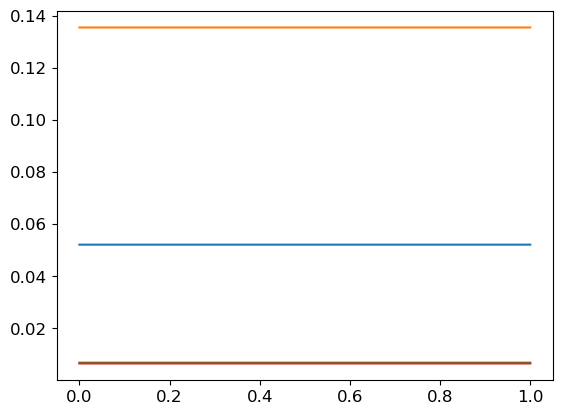

In [45]:
stepsize = ssPP.method_variables()['stepsize__']
plt.plot(np.linspace(0,1,len(stepsize)),stepsize[:,0])
plt.plot(np.linspace(0,1,len(stepsize)),stepsize[:,1])
plt.plot(np.linspace(0,1,len(stepsize)),stepsize[:,2])
plt.plot(np.linspace(0,1,len(stepsize)),stepsize[:,3])

In [46]:
ssPP.step_size

array([0.0520811 , 0.135446  , 0.0067815 , 0.00646466])

In [47]:
prev_stepsizes = ssPP.step_size
print(prev_stepsizes)

[0.0520811  0.135446   0.0067815  0.00646466]


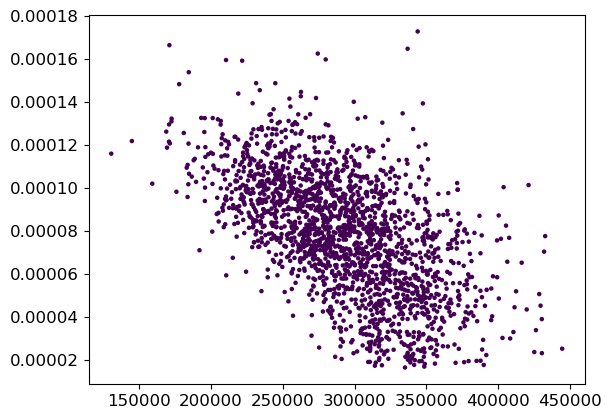

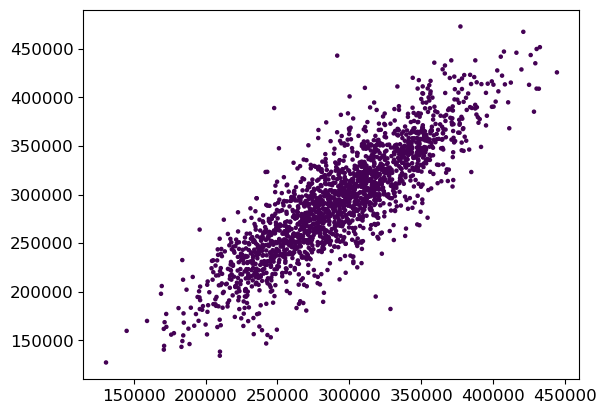

In [137]:
chain = 1
col = chain - 1

# posterior_Emu
# posterior_Vmu
# posterior_Esig
# posterior_Vsig
# posterior_Es
# posterior_Vs
# posterior_gamma

#posterior_Vs[i,:,j]
plt.figure()
plt.scatter(posterior_Esig[col,:], posterior_gamma[col,:], c=divergences[:,col],s=5)
plt.figure()
plt.scatter(posterior_Esig[col,:], posterior_Vs[col,:,5], c=divergences[:,col],s=5)
#plt.ylim(0.00008,0.00015)